# Lab 4 - BCC406

## REDES NEURAIS E APRENDIZAGEM EM PROFUNDIDADE

## Convolução

### Prof. Eduardo e Prof. Pedro

### Aluna: Daniela Costa Terra

Objetivos:
- Aplicação de filtros em imagens por meio de convolução
- Entendimento do uso de stride, padding e pooling
- Modelagem de uma rede de convolução para o problema de rec. de face da AT&T
- Uso do VGG pr-e-treinado como um extrator de caracterĩsticas
- Uso do MobileNet pré-treinado para classificação de faces : transferência de aprenzagem

Data da entrega : 13/05 

- Complete o código (marcado com ToDo) e quando requisitado, escreva textos diretamente nos notebooks. Onde tiver *None*, substitua pelo seu código.
- Execute todo notebook e salve tudo em um PDF **nomeado** como "NomeSobrenome-Lab4.pdf"
- Envie o PDF pelo [FORM](https://forms.gle/FQ6Znfg9Enic6cKd8)

Este notebook é baseado em tensorflow e Keras.

# 1. Aplicando filtros e entendendo padding, stride e pooling (20pt)

## 1.1. Importando pacotes e montando o drive

In [30]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, AvgPool2D
from tensorflow.keras import datasets, layers, models
import os
import skimage
from skimage import io
import numpy as np
import math

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import skimage 
from skimage.io import imread
from skimage.transform import resize

## 1.2. Carregando uma imagem

Carregue um imagem do disco, para usar como exemplo.

sample image shape:  (512, 512, 3)


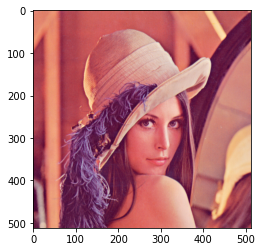

In [33]:
# carrega imagem de exemplo
sample_image = imread("/content/drive/MyDrive/disciplinasDoutorado/PCC177-2022-1(Redes)/lab4/Data/Lenna.png")
sample_image= sample_image.astype(float)

size = sample_image.shape
print("sample image shape: ", sample_image.shape)

plt.imshow(sample_image.astype('uint8'));
#skimage.io.imshow(sample_image[:,:,0].astype('uint8'))

In [34]:
# veja o shape da imagem
sample_image.shape

(512, 512, 3)

## 1.3. Criando e aplicando um filtro com convolução

Utilize o tf/Keras para aplicar o filtro. Observe que nesta etapa não há necessidade de treinamento algum. O código abaixo cria 3 filtros de tamanho 5x5, e adiciona padding de forma a manter a imagem de saída (filtrada) do mesmo tamanho da imagem de entrada (padding ="same").

In [35]:
#cria um objeto sequencial com apenas uma camada de convolução do tipo tf.keras.layers.Conv2D
conv = Sequential([
    Conv2D(filters=3, kernel_size=(5, 5), padding="same",
           input_shape=(512, 512, 3))
])
conv.output_shape

(None, 512, 512, 3)

In [36]:
conv.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 512, 512, 3)       228       
                                                                 
Total params: 228
Trainable params: 228
Non-trainable params: 0
_________________________________________________________________


In [37]:
# com TF/kertas, as convoluções esperam vetores no formato : (batch_size, dim1, dim2, dim3). Ou seja, a primeria posição é o tamanho do lote. 
# Uma imagem isolada é considerada um lote de tamanho 1, portanto, deve-se expandir mais uma dimenão do tensor.
img_in = np.expand_dims(sample_image, 0) 
img_in.shape 

(1, 512, 512, 3)

Agora, pode-se aplicar a convolução. Aplique a convolução na imagem de exemplo (expandida) e verifique o tamanho da imagem resultante (img_out). Use a função predict do objeto conv para aplicar a convolução.

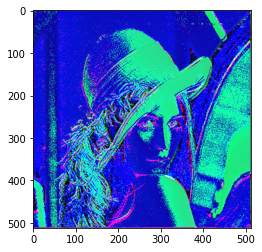

In [38]:
img_out = conv(img_in)
img_out.shape
img_out2 = conv.predict(img_in)
plt.imshow(np.squeeze(img_out).astype('uint8'));
#skimage.io.imshow(np.squeeze(img_out).astype('uint8'))

Plote as imagens lado a lado e observe o resultado. O parâmetro "same" no padding aplica um padding automático no sentido de garantir que a saída tenha o mesmo tamanho da entrada.
Lembre-se que o padding adiciona zeros nas bordas da imagem, antes da aplicação da convolução.

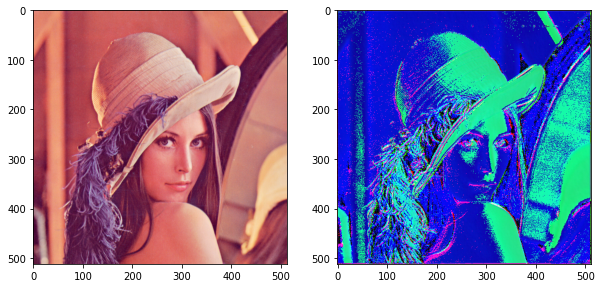

In [39]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(sample_image.astype('uint8'))
ax1.imshow(img_out[0].numpy().astype('uint8'));

Repita o mesmo procedimento, trocando padding de 'same' para 'valid', usando apenas um filtro.

In [40]:
conv2 = Sequential([
    Conv2D(filters=1, kernel_size=(5, 5), padding="valid",
           input_shape=(512, 512, 3))
])
conv2.output_shape

(None, 508, 508, 1)

In [41]:
conv2.summary() # 1 filtro 5x5x3 ... a profundidade do filtro é de acordo com a entrada. 5x5x3 = 75; Não esqueça do bias!

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 508, 508, 1)       76        
                                                                 
Total params: 76
Trainable params: 76
Non-trainable params: 0
_________________________________________________________________


In [42]:
img_out = conv2(img_in)
img_out[0].shape
 

TensorShape([508, 508, 1])

Plote as duas imagens lado a lado

In [43]:
#  Como tivemos que expandir a primeira dimensao para aplicar a convolução, podemos remover a dimensão unitária para plotar a imagem, usando a função squeeze()
i = img_out[0].numpy().squeeze()
i.shape

(508, 508)

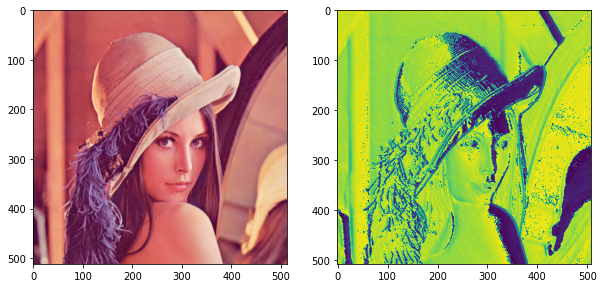

In [44]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(sample_image.astype('uint8'))
i = img_out[0].numpy().squeeze()
ax1.imshow(i.astype('uint8'));
#skimage.io.imshow(i.astype('uint8'))

## 1.4. Inicializando os filtros na mão


A função abaixo inicializa um array de dimensões 5,5,3,3 com todas as posições zero, exceto as posições 5,5,0,0 , 5,5,1,1 e 5,5,2,2 que recebem o valor 1/25.

In [45]:
def my_filter(shape=(5, 5, 3, 3), dtype=None):
    array = np.zeros(shape=shape, dtype=np.float32)
    array[:, :, 0, 0] = 1 / 25
    array[:, :, 1, 1] = 1 / 25
    array[:, :, 2, 2] = 1 / 25
    return array

In [46]:
# transposição apenas para ajudar na visualização
np.transpose(my_filter(), (2, 3, 0, 1))

array([[[[0.04, 0.04, 0.04, 0.04, 0.04],
         [0.04, 0.04, 0.04, 0.04, 0.04],
         [0.04, 0.04, 0.04, 0.04, 0.04],
         [0.04, 0.04, 0.04, 0.04, 0.04],
         [0.04, 0.04, 0.04, 0.04, 0.04]],

        [[0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ]],

        [[0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ]]],


       [[[0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ]],

        [[0.04, 0.04, 0.04, 0.04, 0.04],
         [0.04, 0.04, 0.04, 0.04, 0.04],
         [0.04, 0.04, 0.04, 0.04, 0.04],
         [0.04, 0.04, 0.04, 0.04, 0.04],
      

In [47]:
# a função definida acima é usada para carregar valores nos filtros. 
# use a função my_filter() para pre-inicializar os filtros do objeto conv3. 
# 
conv3 = Sequential([
     Conv2D(filters=3, kernel_size=(5, 5), padding="same",
           input_shape=(512, 512, 3), kernel_initializer=my_filter)
])
conv3.output_shape

(None, 512, 512, 3)

## 1.5. Plote e observe o que acontece com a imagem (1pt)



Foi observada uma redução da nitidez na imagem.

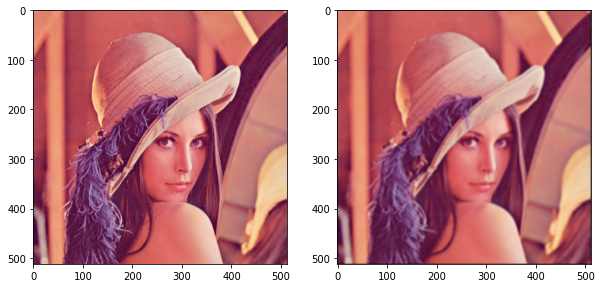

In [48]:
# observe o que aconte com a imagem
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(img_in[0].astype('uint8'))
ax1.imshow(conv3.predict(img_in)[0].astype('uint8'));

### Responda

**ToDo** : Cada conjunto de 3 filtros gerados por my_filter gerou na convolução um filtro da média (para suavização) em cada canal RGB da imagem. 

## 1.6. Filtros de borda (5pt)

**ToDo** : Crie uma nova função para gerar um filtro de borda nos 3 canais da imagem de entrada. O filtro deve ser 3x3 e ter o formato [[0 0.2 0] [0 -0.2 0] [0 0 0]] (2pt)

In [49]:
def my_new_filter(shape=(1, 3, 3, 3), dtype=None):
    array = np.zeros(shape=(3,3,3,1), dtype=np.float32)
    array[0][1][0][0] = 0.2   
    array[1][1][0][0] = -0.2  
    array[0][1][1][0]=0.2
    array[1][1][1][0]=-0.2
    array[0][1][2][0]=0.2
    array[1][1][2][0]=-0.2
    return array

# transposição apenas para ajudar na visualização
x = my_new_filter()

#x , x.shape  #, m_r, m_g, m_b
# transposição apenas para ajudar na visualização
np.transpose(my_new_filter(), (2, 3, 0, 1))

array([[[[ 0. ,  0.2,  0. ],
         [ 0. , -0.2,  0. ],
         [ 0. ,  0. ,  0. ]]],


       [[[ 0. ,  0.2,  0. ],
         [ 0. , -0.2,  0. ],
         [ 0. ,  0. ,  0. ]]],


       [[[ 0. ,  0.2,  0. ],
         [ 0. , -0.2,  0. ],
         [ 0. ,  0. ,  0. ]]]], dtype=float32)

Inicialize o objeto conv4 com seu novo filtro e aplique na imagem de entrada

In [50]:
conv4 = Sequential([
    Conv2D(filters=1, kernel_size=(3, 3), padding="same",
           input_shape=(512, 512, 3), kernel_initializer=my_new_filter)
])

conv4.output_shape

(None, 512, 512, 1)

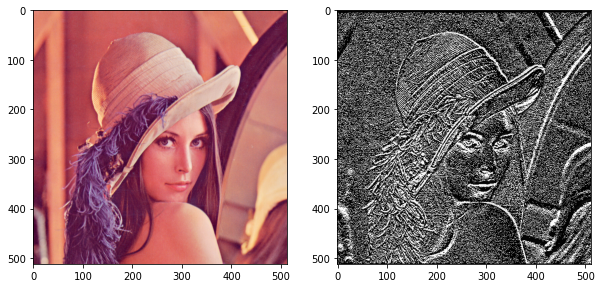

In [51]:
output = conv4.predict(img_in) 
out_im = np.squeeze(output[0])
output.shape, out_im.shape

# Plote as duas iamgens lado a lado (filtrada e não filtrada)
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(img_in[0].astype('uint8'))
ax1.imshow(out_im.astype('uint8'), cmap = 'gray');  


## 1.7. Pooling (14pt)



Aplique um max-pooling na imagem, com uma janela de 2x2. Faça com stride de 2 e observe o resultado na imagem de saída. 

In [52]:
# cria um objeto Sequencial de nome max_pool, apenas contendo uma camada de tf.keras.layer.MaxPool2D.
# lembre-se de colocar o parametro input-shape como input_shape=(None, None, 3)

max_pool = Sequential([
                       MaxPool2D(pool_size=(2, 2), strides = 2, input_shape=(None, None, 3))
                       ])# ToDo ...


In [53]:
img_in = np.expand_dims(sample_image, 0) # expande a imagem
img_out = max_pool.predict(img_in) # aplica o pooling
img_in[0].shape, img_out[0].shape

((512, 512, 3), (256, 256, 3))

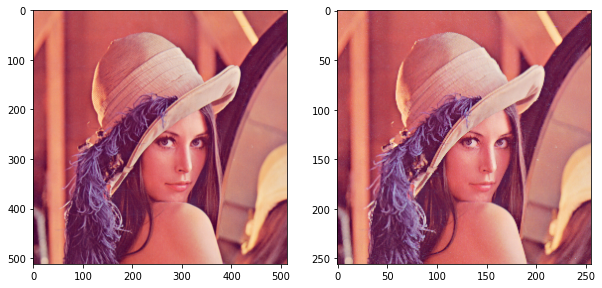

In [54]:
# plota as imagens lado a lado
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(img_in[0].astype('uint8'))
ax1.imshow(img_out[0].astype('uint8'));

Aumente o stride para 4, repita o processo e observe o resultado na imagem de saída.




In [55]:
from keras.layers.pooling import MaxPool1D
# cria um objeto Sequencial de nome max_pool, apenas contendo uma camada de tf.keras.layer.MaxPool2D.
# lembre-se de colucar o parametro input-shape como input_shape=(None, None, 3)
# Coloque o parametro stride para 4

max_pool2 = Sequential( [ MaxPool2D(pool_size=(2,2), strides = 4, input_shape=(None, None, 3))
                         ])

In [56]:
img_in = np.expand_dims(sample_image, 0) # expande a imagem
img_out = max_pool2.predict(img_in) # aplica o pooling
img_in[0].shape, img_out[0].shape

((512, 512, 3), (128, 128, 3))

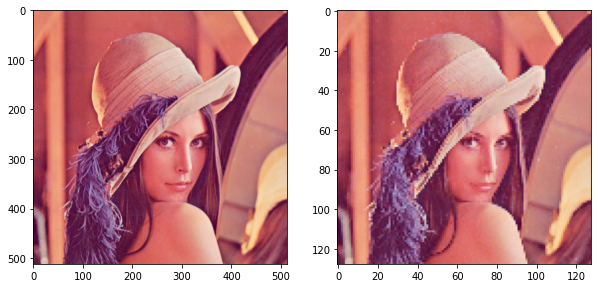

In [57]:
# plota as imagens lado a lado
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(img_in[0].astype('uint8'))
ax1.imshow(img_out[0].astype('uint8'));

Aumente o stride para 8, repita o processo e observe o resultado na imagem de saída. A

In [58]:
# cria um objeto Sequencial de nome max_pool, apenas contendo uma camada de tf.keras.layer.MaxPool2D.
# lembre-se de colucar o parametro input-shape como input_shape=(None, None, 3)
# Coloque o parametro stride para 4

max_pool3 = Sequential([MaxPool2D(pool_size=(2,2), strides = 8, input_shape=(None, None, 3))])
                       

In [59]:
img_in = np.expand_dims(sample_image, 0) # expande a imagem
img_out = max_pool3.predict(img_in) # aplica o pooling
img_in.shape, img_out.shape

((1, 512, 512, 3), (1, 64, 64, 3))

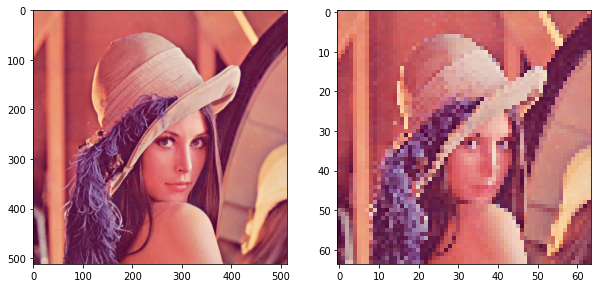

In [60]:
# plota as imagens lado a lado
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(img_in[0].astype('uint8'))
ax1.imshow(img_out[0].astype('uint8'));

### Responda

**ToDo** - 
* Para stride 2, em cada canal ocorre que: cada janela do pool tamanho (2,2) seleciona o pixel de maior intensidade para a imagem de saída. A resolução da imagem de saída é 4 vezes menor: (h/2 x w/2).
* Para stride 4, em cada canal ocorre que: cada aplicação do maxpool (2,2) seleciona o pixel de maior intensidade. Contudo para cada passo (de 4 px) na horizontal/vertial, uma janela (2,2) é desconsiderada. Numa vizinhança 6x6 pixesl da imagem original, apenas 4 janelas (2x2) são aplicadas, assim apenas 4 pixels são calculados para a saída. A resolução da imagem de saída será 16 vezes menor, com dimensão: (h/4 x w/4).
* Para stride 8, o raciocínio é análogo: para cada passo (stride 8px) na horizontal ou na vertial, apenas uma janela (2,2) é considerada. Numa vizinhança 10x10 pixesl da imagem original, apenas 4 janelas (2x2) são aplicadas, assim apenas 4 pixels serão calculados para a saída. A resolução da imagem de saída será 64 vezes menor, com dimensão: (h/8 x w/8).

# 2. Reconhecimento de Faces usando uma rede de convolução (20pt)




O objetivo desta etapa é classificar faces na base ORL (AT&T) Database (40 individuos x 10 imagens, de resolução 112x92 pixels e 256 níveis de cinza).

Baixe as imagens no site http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html ou da pasta dataset do Drive.

## 2.1. Preparando os dados (5pt)

In [61]:
# carregue as imagens 

# inicializa matrizes X e y
X = np.empty([400, 112, 92]) # 40 classe com 10 imgs cada, 10304 = 112x92
y = np.empty([400, 1])

# percorre todos os diretorios da base att e carrega as imagens
imgs_path = "/content/drive/MyDrive/disciplinasDoutorado/PCC177-2022-1(Redes)/lab4/Data/att_faces"
#imgs_path = "<my path>/datasets/att_faces"
i=0
class_id = 0
for f in os.listdir(imgs_path): 
    #print(f)
    if f.startswith("s"):
        class_id = class_id + 1
        for img_path in os.listdir(os.path.join(imgs_path,f)):
            if img_path.endswith(".pgm"):
                #print(img_path)
                X[i, :, :] = io.imread(os.path.join(imgs_path,f,img_path))
                y[i, :] = class_id        
                i = i + 1
 

print("dimensões da matriz X = " , X.shape)
 

dimensões da matriz X =  (400, 112, 92)


In [62]:
# Divida os dados em treino e teste (70%-30%) com a função train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)

In [63]:
print(X_train.shape, y_train.shape)

(280, 112, 92) (280, 1)


In [64]:
print(X_test.shape, y_test.shape)
#np.sum(y_test == 1), np.sum(y_test == 2), np.sum(y_test == 3)

(120, 112, 92) (120, 1)


## 2.2. Implementando a rede (15pt)

Implemente uma rede de convolução simples, contendo 3 camadas de convolução seguidas de camadas max-pooling. Duas camadas densas (totalemtne conectadas) no final e por fim uma camada com ativação softmax para a classificação. Escolha filtros de tamanhos variados : (3,3) ou (5,5). Para cada camada, crie de 32 a 96 filtros. 
Na camada densa, use de 64 a 200 neurônios.

Use o comando model.summary() para conferir a arquitetura. 

In [65]:
from sklearn.utils.extmath import softmax
# Implementa uma rede de convolução simples, chamada model

def net(initializer, activation = "relu", k_conv1=(3,3), k_conv2=(3,3), k_conv3=(3,3), f_conv1=32, f_conv2=64,  f_conv3=64, n_fc=64, input_shape = (112, 92,1)):
    model = tf.keras.models.Sequential() 
    model.add(tf.keras.layers.InputLayer(input_shape=input_shape))
 
    if activation == "relu":
        model.add(Conv2D(filters=f_conv1, kernel_size = k_conv1, padding='valid', kernel_initializer=initializer))
        model.add(tf.keras.layers.ReLU()) 
        model.add(MaxPool2D(pool_size=(2,2), strides=2))
        model.add(Conv2D(filters=f_conv2, kernel_size = k_conv2, padding='valid', kernel_initializer=initializer))
        model.add(tf.keras.layers.ReLU()) 
        model.add(MaxPool2D(pool_size=(2,2), strides=2))
        model.add(Conv2D(filters=f_conv3, kernel_size = k_conv3, padding='valid', kernel_initializer=initializer))
        model.add(tf.keras.layers.ReLU()) 
        model.add(MaxPool2D(pool_size=(2,2), strides=2))
        model.add(layers.Flatten())
        model.add(layers.Dense(n_fc, kernel_initializer=initializer))
        model.add(layers.ReLU()) 
    else: 
        model.add(Conv2D(filters=f_conv1, kernel_size = k_conv1, padding='valid', kernel_initializer=initializer, activation = activation))
        model.add(MaxPool2D(pool_size=(2,2), strides=2))
        model.add(Conv2D(filters=f_conv2, kernel_size = k_conv2, padding='valid', kernel_initializer=initializer, activation = activation))
        model.add(MaxPool2D(pool_size=(2,2), strides=2))
        model.add(Conv2D(filters=f_conv3, kernel_size = k_conv3, padding='valid', kernel_initializer=initializer, activation = activation))
        model.add(MaxPool2D(pool_size=(2,2), strides=2))
        model.add(layers.Flatten())
        model.add(layers.Dense(n_fc, activation = activation, kernel_initializer=initializer))
        
    model.add(layers.Dense(40, activation = 'softmax',kernel_initializer=initializer)) 
    return model  

# treina a rede
def train(net, data_train, label_train, epochs=30, batch_size = 100):
    # treinamento 
    hist = net.fit(data_train, label_train, batch_size = batch_size, epochs= epochs, verbose=0)

    # Curvas de aprendizagem:
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.plot(np.squeeze(hist.history['loss']))
    ax1.set_title('Training loss')
    ax2.plot(np.squeeze(hist.history['accuracy']))
    ax2.set_title('Training accuracy')
    #ax2.set_ybound(lower=0, upper=100)
    ax2.axis([0, 30, 0, 50])
    
    plt.show()
    return hist
    
def predict (net, data_test, label_test):
    return net.evaluate(data_test, label_test, verbose=1)

def run (net, data_test):
    return net(data_test)


In [66]:

# Rede 1 (3 Conv2D, 2FC, softmax):

input_size = (X.shape[1], X.shape[2],1)
n_classes = 40
 
model = net(initializer = 'glorot_uniform', activation = "relu", 
            k_conv1=(3,3), k_conv2=(3,3), k_conv3=(3,3), 
            f_conv1=32, f_conv2=64,  f_conv3=64, 
            n_fc=64, input_shape = input_size)  #input_shape = (None, 112, 92,1))
                       
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 110, 90, 32)       320       
                                                                 
 re_lu (ReLU)                (None, 110, 90, 32)       0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 55, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 53, 43, 64)        18496     
                                                                 
 re_lu_1 (ReLU)              (None, 53, 43, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 26, 21, 64)       0         
 2D)                                                  

Seu modelo deve ter uma saída aproximadamente como abaixo:



```
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d_60 (Conv2D)           (None, 110, 90, 32)       320       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 55, 45, 32)        0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 53, 43, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 26, 21, 64)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 24, 19, 64)        36928     
_________________________________________________________________
flatten_5 (Flatten)          (None, 29184)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                1867840   
_________________________________________________________________
dense_10 (Dense)             (None, 40)                2600      
=================================================================
Total params: 1,926,184
Trainable params: 1,926,184
Non-trainable params: 0
_________________________________________________________________
```



In [67]:
# repare bem o shape de x_train. A priumeira dimensão é o tamanho do lote, a segunda e terceira são referentes ao taamnho das imagens.
# repare que as imagens desta base tem apenas uma banda (escala de cinza) 
X_train.shape

(280, 112, 92)

In [68]:
# Como o tensor acima não contempla o tamanho de canais (no caso , igual a 1), deve-se expandir a última dimensão para deixar a entrada compatĩvel com o que é esperado pelo modelo do tf.keras
X_train_new = np.expand_dims(X_train, axis = 3)  # Todo ..
X_test_new = np.expand_dims(X_test, axis = 3) # Todo ..

X_train_new.shape, X_test_new.shape

((280, 112, 92, 1), (120, 112, 92, 1))

In [69]:
# o vetor de rótulos não precisa ter duas diemnões.
y_train_new = y_train.squeeze()
y_test_new = y_test.squeeze()

# e deve ficar na faixa entre 0 e 39
y_train_new = y_train_new - 1; 
y_test_new = y_test_new - 1;

y_train_new.shape, y_test_new.shape

((280,), (120,))

Compile o modelo usando o método de otimização=adam e função de custo (loss) = sparse_categorical_crossentropy. 

In [70]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
trainer = tf.keras.optimizers.Adam(learning_rate=0.0075, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=trainer, loss=loss, metrics=['accuracy']) # Todo ...

Treine o modelo por 30 épocas com batch_size = 100.

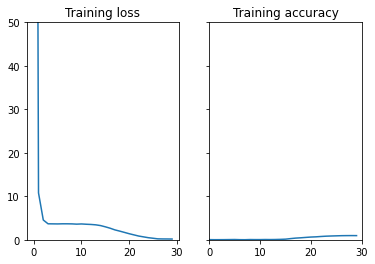

In [71]:
history = train(model, X_train_new, y_train_new, epochs=30,  batch_size = 100)

# history = model.fit( # Todo ...

O retorno da função fit() é um objeto para armazenar o histõrico do treino.

In [72]:
history.history.keys() #, history.history['accuracy'], history.history['loss']

dict_keys(['loss', 'accuracy'])

Plote a acurácia e o custo (loss) do treino e da validação.

Last Loss: 0.1761210560798645
Last Accuracy: 0.9607142806053162


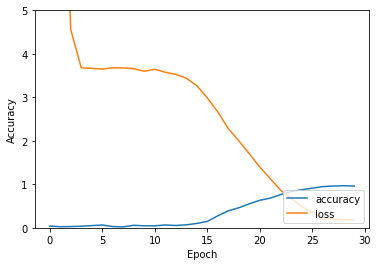

In [73]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.ylim([0.0, 1.1])
plt.legend(loc='lower right')

plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 5])
plt.legend(loc='lower right')


#model.metrics_names
print('Last Loss: '+ str(history.history['loss'][-1]))
print('Last Accuracy: '+ str(history.history['accuracy'][-1]))

In [74]:
test_loss, test_acc = model.evaluate(X_test_new,  y_test_new, verbose=2)

print(test_acc, test_loss)

4/4 - 1s - loss: 2.7791 - accuracy: 0.6833 - 588ms/epoch - 147ms/step
0.6833333373069763 2.7791481018066406


# 3. Usando um modelo Pré-treinado : VGG (10pt)

Carregando os dados da base AT&T para o VGG. Como a base está em escala de cinza e a entrada do modelo VGG espera uma imagem colorida (RGB), vamos repetir a mesma imagem em cada uma das bandas.

## 3.1. Preparando os dados (2pt)


In [75]:
import cv2

# inicializa matrizes X e y
X = np.empty([400, 112, 92, 3]) # 40 classe com 10 imgs cada, 10304 = 112x92
y = np.empty([400, 1])

# percorre todos os diretorios da base att e carrega as imagens
imgs_path = "/content/drive/MyDrive/disciplinasDoutorado/PCC177-2022-1(Redes)/lab4/Data/att_faces"
i=0
class_id = 0
for f in os.listdir(imgs_path): 
    #print(f)
    if f.startswith("s"):
        class_id = class_id + 1
        for img_path in os.listdir(os.path.join(imgs_path,f)):
            if img_path.endswith(".pgm"):
                #print(img_path)
                # copia msg imagem para os 3 canais
                img = io.imread(os.path.join(imgs_path,f,img_path))
                X[i, :, :,0] = img
                X[i, :, :,1] = img
                X[i, :, :,2] = img
                y[i, :] = class_id-1        
                i = i + 1
 



In [76]:
# divida em 70% treino e 30% teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)  # Todo ...

X_train.shape, X_test.shape

((280, 112, 92, 3), (120, 112, 92, 3))

## 3.2. Carrando o VGG direto da biblioteca do tensorflow (2pt)

In [77]:
# https://www.tensorflow.org/guide/keras/functional?hl=pt_br

from tensorflow.keras.applications import VGG19
vgg19 = VGG19()

In [78]:
vgg19.summary() # repare a quantidade de parãmetros!

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Vamos descartar as duas últimas camadas do VGG

In [79]:
# https://www.tensorflow.org/guide/keras/functional?hl=pt_br
from tensorflow.keras.models import Model

vgg_face_descriptor = Model(inputs=vgg19.layers[0].input, outputs=vgg19.layers[-2].output)

#vgg_face_descriptor.summary()

### Responda

**ToDo** - Por que descartamos as duas últimas camadas do VGG?

Resp.:

O código acima não excluí as 2 últimas camadas, e sim apenas a última camada de classificação, saída da VGG19.

Em casos de transferência de aprendizagem, a camada final de classificação deve ser substituída por uma camada adaptada ao número de classes do problema alvo. Além disso, as últimas camadas podem ser treinadas, num ajuste fino, ao problema alvo já que essas são mais específicas à classificação alvo, em contraposição das camadas iniciais de convolução cujos pesos podem ser preservados para extração de padrões de alto nível (raw patterns).

Mas voltando ao exemplo dessa atividade. A transferência de aprendizagem se deu a partir de uma rede pré-treinada para um problema de classificação de 1000 classes. A última camada  deve ser substituída para ter 40 neurônios, um para cada classe da base alvo (AT&T). Embora a adaptação da camada final não foi feita, o exercício de similaridade mostrou a importância dos filtros pré-treinados, evidenciando uma tendência de separação de classes mesmo para predição de outros dados como da base AT&T.

## 3.3 Medindo Similaridade

### As funções abaixo servem para medir similaridade entre duas imagens, passando-se um vetor de características.

In [80]:
def findCosineSimilarity(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

def findEuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

### A função verifyFace recebe duas imagens e calcula a similaridade entre elas. Se a similaridade for menor que epsilon, afirma-se que as duas imagens são de uma mesma pessa.

In [81]:
epsilon = 0.0040

def verifyFace(img1, img2):
    
    img1_representation = vgg_face_descriptor.predict(img1, steps=None)[0,:]
    img2_representation = vgg_face_descriptor.predict(img2, steps=None)[0,:]
    
    cosine_similarity = findCosineSimilarity(img1_representation, img2_representation)
    euclidean_distance = findEuclideanDistance(img1_representation, img2_representation)
    
    print("Similaridade com distancia do cosseno: ",cosine_similarity)
    print("Similaridade com distancia euclideana: ",euclidean_distance)
    
    if(cosine_similarity < epsilon):
        print("Verificado! Mesma pessoa!")
    else:
        print("Não-verificado! Não são a mesma pessoa!")
    
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(np.squeeze(img1))
    plt.xticks([]); plt.yticks([])
    f.add_subplot(1,2, 2)
    plt.imshow(np.squeeze(img2))
    plt.xticks([]); plt.yticks([])
    plt.show(block=True)
    print("-----------------------------------------")

### Verificando a similaridade entre imagens (6pt)

Para 4 pares de imagens da base da AT&T e faça uma verificação entre elas, chamando a função verifyFace().

Antes de usar o VGG como um extrator de caracteristicas, normalize os dados dividindo os pixels por 255. Além disso, re-escalone as imagesn para o formato 224x224. Use a biblioteca OpenCV (cv2). 

Faça para os pares : 64 e 33, 3 e 7, 40 e 44, 100 e 200.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Similaridade com distancia do cosseno:  0.005428433418273926
Similaridade com distancia euclideana:  4.7904844
Não-verificado! Não são a mesma pessoa!


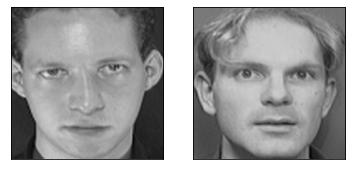

-----------------------------------------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Similaridade com distancia do cosseno:  0.0051419734954833984
Similaridade com distancia euclideana:  4.6457305
Não-verificado! Não são a mesma pessoa!


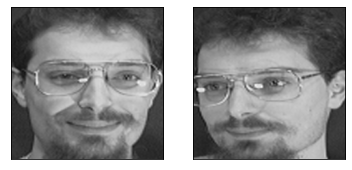

-----------------------------------------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Similaridade com distancia do cosseno:  0.0017830133438110352
Similaridade com distancia euclideana:  2.7902482
Verificado! Mesma pessoa!


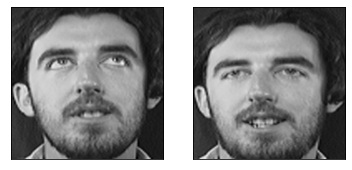

-----------------------------------------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Similaridade com distancia do cosseno:  0.006726205348968506
Similaridade com distancia euclideana:  5.520715
Não-verificado! Não são a mesma pessoa!


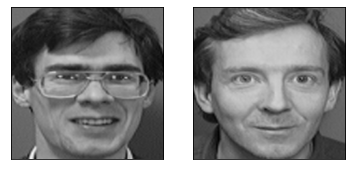

-----------------------------------------


In [82]:
import cv2

# Ajuste as imagens para a entrada do modelo VGG 


# Obs.: uso de imagens já redimensionadas na variável X_r

# exemplo, para o par 64 e 33 :
# Todo : Normaliza entre 0 e 1 , dividindo por 255
img1 = X[64,:,:,:]/255 # Todo
img2 = X[33,:,:,:]/255 # Todo

# Demais pares :
img3 = X[3,:,:,:]/255 # Todo
img4 = X[7,:,:,:]/255 # Todo

img5 = X[40,:,:,:]/255 # Todo
img6 = X[44,:,:,:]/255 # Todo

img7 = X[100,:,:,:]/255 # Todo
img8 = X[200,:,:,:]/255 # Todo

# Redimensione a imagem para (224,224) e coloca a primeira dimensão unitária
# Resp.: imagens já redimensionadas no bloco de carregamento
img1 = cv2.resize(img1, (224,224), interpolation = cv2.INTER_CUBIC) # Todo
img2 = cv2.resize(img2, (224,224), interpolation = cv2.INTER_CUBIC) # Todo
img3 = cv2.resize(img3, (224,224), interpolation = cv2.INTER_CUBIC) # Todo
img4 = cv2.resize(img4, (224,224), interpolation = cv2.INTER_CUBIC) # Todo
img5 = cv2.resize(img5, (224,224), interpolation = cv2.INTER_CUBIC) # Todo
img6 = cv2.resize(img6, (224,224), interpolation = cv2.INTER_CUBIC) # Todo
img7 = cv2.resize(img7, (224,224), interpolation = cv2.INTER_CUBIC) # Todo
img8 = cv2.resize(img8, (224,224), interpolation = cv2.INTER_CUBIC) # Todo

# lembre-se de expandir a primeira dimensão, pois nosso lote aqui é de 1 imagem
img1 = np.expand_dims(img1, axis=0) # Todo ..
img2 = np.expand_dims(img2, axis=0) # Todo ..
img3 = np.expand_dims(img3, axis=0) # Todo ..
img4 = np.expand_dims(img4, axis=0) # Todo ..
img5 = np.expand_dims(img5, axis=0) # Todo ..
img6 = np.expand_dims(img6, axis=0) # Todo ..
img7 = np.expand_dims(img7, axis=0) # Todo ..
img8 = np.expand_dims(img8, axis=0) # Todo ..
 
verifyFace(img1, img2)
verifyFace(img3, img4)
verifyFace(img5, img6)
verifyFace(img7, img8)

# 4. Transferência de aprendizado (50pt)


Estude o tutorial do [link](https://www.tensorflow.org/tutorials/images/transfer_learning) e aplique o mesmo procedimento para ajustar um modelo previamente treinado com imagens da imagenet. 
Use o MobileNetV2 como modelo base.

Faça o procedimento em duas etapas:


1.   Congele todas as camadas exceto as novas que você adicinou ao modelo. Treine.
2.   Libere todas as camadas paar o treinamento e treine novamente com um Learning Rate bem pequeno (um décimo do realizado no ítem 1).

In [83]:
# Usando o mobileNet, as imagens devem ter entrada de 160x160x3 e normalizadas entre -1 e 1. 
# Use a funçao abaixo para fazer o trabalho, conjuntamente com tf.data.Dataset.from_tensor_slices

IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [84]:
X_train.shape

(280, 112, 92, 3)

In [85]:
# Tensorflow tem funções especĩficas para carregar os dados. Veja tf.data.Dataset

raw_train = tf.data.Dataset.from_tensor_slices((X_train,y_train))
raw_test = tf.data.Dataset.from_tensor_slices((X_test,y_test))

In [86]:
train = raw_train.map(format_example)
test = raw_test.map(format_example)


Seus dados devem ter o formato :



```
TensorShape([Dimension(280), Dimension(160), Dimension(160), Dimension(3)])

```



In [87]:
shuffle_buffer_size = X_train.shape[0]
BATCH_SIZE = 40
train_batches = train.shuffle(shuffle_buffer_size).batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

# Todo
# 5. Dentre os dados de treinamento, reserve 10% para validação do modelo:
num_train_batches = tf.data.experimental.cardinality(train_batches)
num_test_batches = tf.data.experimental.cardinality(test_batches)
batches_take = math.ceil(int(num_train_batches)*0.1)
print(batches_take)
val_batches = train_batches.take(batches_take)
train_batches = train_batches.skip(batches_take)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_batches))
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_batches))

1
Number of validation batches: 1
Number of train batches: 6


## 4.1. Execute os passos (35pt):

1. Carregue o modelo pré-treinado do MobileNet, remova a última camada. 
2. Adicione uma camdada de Global Average Pooling 2D (GAP)
3. Adicione uma camada densa para ajustar ao seu número de classes e use ativação softmax
4. Use função de custo loss='sparse_categorical_crossentropy'
5. Dentre os dados de treinamento, reserve 10% para validação do modelo.
6. Treine por 10 épocas.
7. Plote os gráficos de custo do treino e validação




In [88]:
# Todo
#1. Carregue o modelo pré-treinado do MobileNet, remova a última camada. 

IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


# 2. Adicione uma camdada de Global Average Pooling 2D (GAP):
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

#3. Adicione uma camada densa para ajustar ao seu número de classes e use ativação softmax
prediction_layer = tf.keras.layers.Dense(40, activation='softmax')

# Definição do modelo:
base_model.trainable = False

inputs = tf.keras.Input(shape=(160, 160, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.summary()




Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 40)                51240     
                                                                 
Total params: 2,309,224
Trainable params: 51,240
Non-trainable params: 2,257,984
_________________________________________________________________


In [89]:
# TODO 
# Etapa 1) Congele todas as camadas exceto as novas que você adicinou ao modelo. Treine:

# 4. Use função de custo loss='sparse_categorical_crossentropy'
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])



Epoch 1/10
6/6 [==============================] - 8s 912ms/step - loss: 4.1410 - accuracy: 0.0375 - val_loss: 3.9843 - val_accuracy: 0.0250
Epoch 2/10
6/6 [==============================] - 4s 739ms/step - loss: 3.9117 - accuracy: 0.0542 - val_loss: 3.7979 - val_accuracy: 0.0500
Epoch 3/10
6/6 [==============================] - 4s 743ms/step - loss: 3.7914 - accuracy: 0.0625 - val_loss: 3.8497 - val_accuracy: 0.0750
Epoch 4/10
6/6 [==============================] - 4s 744ms/step - loss: 3.7013 - accuracy: 0.0875 - val_loss: 3.5807 - val_accuracy: 0.0500
Epoch 5/10
6/6 [==============================] - 4s 742ms/step - loss: 3.6136 - accuracy: 0.0958 - val_loss: 3.4673 - val_accuracy: 0.1000
Epoch 6/10
6/6 [==============================] - 4s 738ms/step - loss: 3.4593 - accuracy: 0.1333 - val_loss: 3.3553 - val_accuracy: 0.1500
Epoch 7/10
6/6 [==============================] - 4s 732ms/step - loss: 3.3992 - accuracy: 0.1333 - val_loss: 3.3326 - val_accuracy: 0.1750
Epoch 8/10
6/6 [====

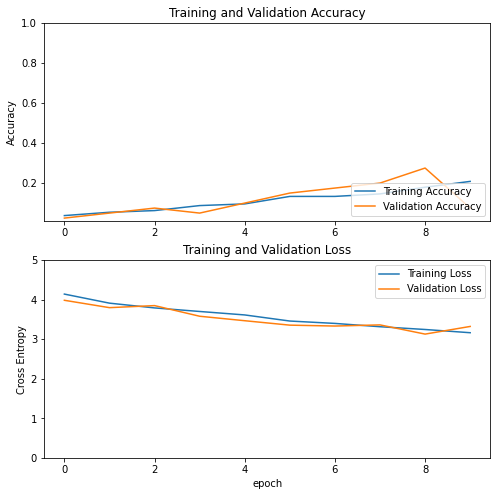

In [90]:
# 6.  Treine por 10 épocas.
initial_epochs = 10
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=val_batches)

# 7. Plote os gráficos de custo do treino e validação
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [91]:
# TODO 
# Etapa 2) Ajuste fino: 

base_model.trainable = True
print("Numero de camadas no base_model: ", len(base_model.layers))

# Fine-tune a partir da camada 100
fine_tune_at = 100

# Congela todas as camadas antes da camada `fine_tune_at` 
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
model.summary()


Numero de camadas no base_model:  154
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 40)                51240     
                                                                 
Total params: 2,309,224
Trainable params: 1,912,680
Non-trainable params: 396,544
_________________________________________________________________


Epoch 10/20
6/6 [==============================] - 18s 2s/step - loss: 2.8940 - accuracy: 0.2292 - val_loss: 2.3119 - val_accuracy: 0.5750
Epoch 11/20
6/6 [==============================] - 8s 1s/step - loss: 2.3017 - accuracy: 0.5000 - val_loss: 1.9119 - val_accuracy: 0.7000
Epoch 12/20
6/6 [==============================] - 8s 1s/step - loss: 1.9386 - accuracy: 0.6917 - val_loss: 1.5737 - val_accuracy: 0.9000
Epoch 13/20
6/6 [==============================] - 8s 1s/step - loss: 1.5562 - accuracy: 0.7958 - val_loss: 1.4928 - val_accuracy: 0.8000
Epoch 14/20
6/6 [==============================] - 8s 1s/step - loss: 1.3871 - accuracy: 0.8167 - val_loss: 1.4750 - val_accuracy: 0.8750
Epoch 15/20
6/6 [==============================] - 7s 1s/step - loss: 1.1433 - accuracy: 0.8833 - val_loss: 0.9367 - val_accuracy: 0.9750
Epoch 16/20
6/6 [==============================] - 8s 1s/step - loss: 1.0177 - accuracy: 0.9208 - val_loss: 1.0774 - val_accuracy: 0.9500
Epoch 17/20
6/6 [================

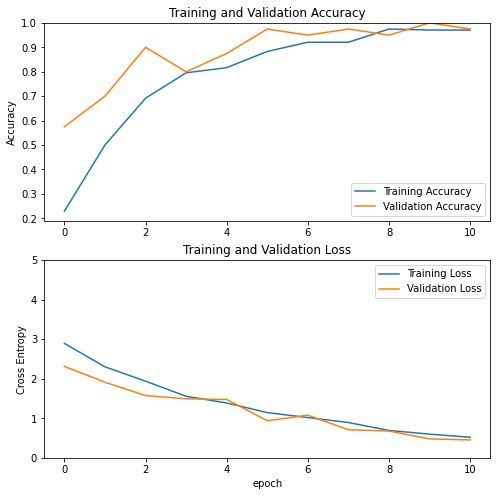

In [92]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs
 
history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_batches)

# 7. Plote os gráficos de custo do treino e validação
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## 4.2. Fazendo testes (13pt)

In [93]:
# Avaliando no conjunto de testes:
loss, accuracy = model.evaluate(test_batches)
print('Test accuracy :', accuracy)


3/3 [==============================] - 2s 577ms/step - loss: 0.8234 - accuracy: 0.9000
Test accuracy : 0.8999999761581421


Analize os gráficos. Você provavelmente deve ter observado overfitting. 
Aplique algumas regularizações no modelo, para tentar reduzir o super-ajuste.



1.   Dropout, antes da camada densa, de 50%
2.   Regularização nos pesos da camada densa (L1 ou L2)
3.   Dropout antes da camada de GAP



Veja exemplos no [link](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)

In [94]:
# Definição do modelo:
base_model.trainable = False

prediction_layer = tf.keras.layers.Dense(40, activation='softmax', 
                 kernel_regularizer=tf.keras.regularizers.L2(0.001))

inputs = tf.keras.Input(shape=(160, 160, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.Dropout(0.2)(x)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 dropout_2 (Dropout)         (None, 5, 5, 1280)        0         
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 dense_5 (Dense)             (None, 40)                5124

In [95]:
# Etapa 1) Congele todas as camadas exceto as novas que você adicinou ao modelo. Treine:

# 4. Use função de custo loss='sparse_categorical_crossentropy'
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


Epoch 1/10
6/6 [==============================] - 8s 933ms/step - loss: 8.6894 - accuracy: 0.0375 - val_loss: 7.1027 - val_accuracy: 0.0250
Epoch 2/10
6/6 [==============================] - 4s 744ms/step - loss: 8.0371 - accuracy: 0.0250 - val_loss: 6.3662 - val_accuracy: 0.0500
Epoch 3/10
6/6 [==============================] - 4s 742ms/step - loss: 7.7135 - accuracy: 0.0250 - val_loss: 5.3415 - val_accuracy: 0.0750
Epoch 4/10
6/6 [==============================] - 4s 755ms/step - loss: 7.2857 - accuracy: 0.0250 - val_loss: 4.6721 - val_accuracy: 0.0750
Epoch 5/10
6/6 [==============================] - 4s 754ms/step - loss: 6.5580 - accuracy: 0.0583 - val_loss: 4.3149 - val_accuracy: 0.1250
Epoch 6/10
6/6 [==============================] - 4s 757ms/step - loss: 6.2323 - accuracy: 0.0542 - val_loss: 4.1700 - val_accuracy: 0.0750
Epoch 7/10
6/6 [==============================] - 4s 747ms/step - loss: 6.2194 - accuracy: 0.0417 - val_loss: 3.5656 - val_accuracy: 0.1750
Epoch 8/10
6/6 [====

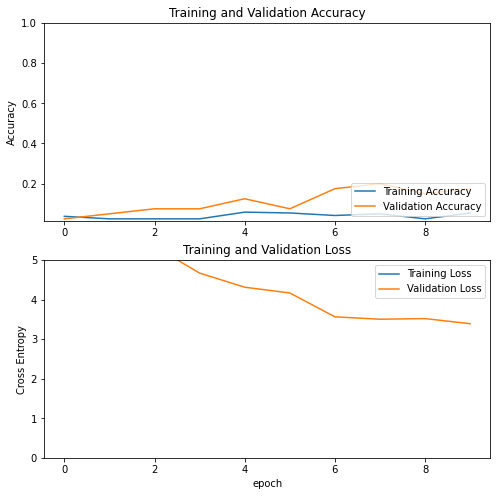

In [96]:
# 6.  Treine por 10 épocas.
initial_epochs = 10
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=val_batches)

# 7. Plote os gráficos de custo do treino e validação
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [97]:
# Etapa 2) Ajuste fino: 

base_model.trainable = True
print("Numero de camadas no base_model: ", len(base_model.layers))

# Fine-tune a partir da camada 100
fine_tune_at = 100

# Congela todas as camadas antes da camada `fine_tune_at` 
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
model.summary()

Numero de camadas no base_model:  154
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 dropout_2 (Dropout)         (None, 5, 5, 1280)        0         
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 dense_5 (Dense)     

Epoch 10/20
6/6 [==============================] - 15s 1s/step - loss: 5.3049 - accuracy: 0.0583 - val_loss: 3.3167 - val_accuracy: 0.1000
Epoch 11/20
6/6 [==============================] - 8s 1s/step - loss: 4.2386 - accuracy: 0.0625 - val_loss: 3.2717 - val_accuracy: 0.1250
Epoch 12/20
6/6 [==============================] - 8s 1s/step - loss: 3.6874 - accuracy: 0.1125 - val_loss: 3.1060 - val_accuracy: 0.2500
Epoch 13/20
6/6 [==============================] - 8s 1s/step - loss: 3.5441 - accuracy: 0.1042 - val_loss: 2.8514 - val_accuracy: 0.4000
Epoch 14/20
6/6 [==============================] - 9s 2s/step - loss: 3.3582 - accuracy: 0.1500 - val_loss: 2.7626 - val_accuracy: 0.3500
Epoch 15/20
6/6 [==============================] - 8s 1s/step - loss: 3.2115 - accuracy: 0.1917 - val_loss: 2.5289 - val_accuracy: 0.4500
Epoch 16/20
6/6 [==============================] - 8s 1s/step - loss: 3.0552 - accuracy: 0.1958 - val_loss: 2.1765 - val_accuracy: 0.6250
Epoch 17/20
6/6 [================

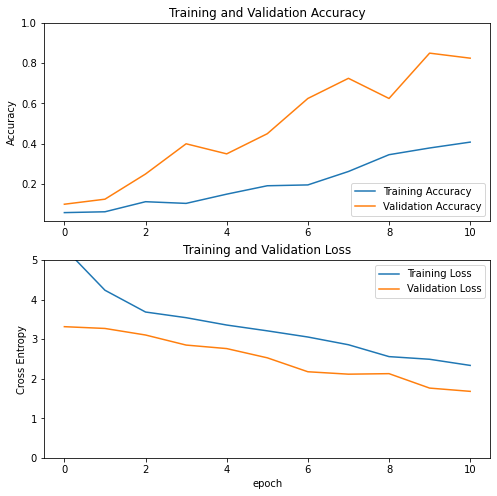

In [98]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs
 
history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_batches)

# 7. Plote os gráficos de custo do treino e validação
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [100]:
# Avaliando no conjunto de testes:
loss, accuracy = model.evaluate(test_batches)
print('Test accuracy :', accuracy)

3/3 [==============================] - 4s 1s/step - loss: 2.0355 - accuracy: 0.6583
Test accuracy : 0.6583333611488342


### Responda (2pt)

**ToDo** - com qual configuração conseguiu resolver o overfitting?

Resp.:  Os gráficos de loss e acurácia para treino e validação não evidenciam overfiting na primeira versão do modelo, sem regularização. Nesse caso,  a generalização do modelo foi superior (acurácia de teste de 0.89) à ultima versão que combinou regularização com weight decay e dropout. O modelo com weight decay e dropout apresentou underfiting. 
